## Importing liberies

In [1]:
from Modules import *
#preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier

#Analysis/Optimization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Other
import numpy as np
import pandas as pd
import pickle

## Open data from .csv

In [2]:
df_train = pd.read_csv('train_preproc.csv')

### Split data to train/test

In [3]:
X = df_train['description_proc']
y = df_train['cc3']
X.shape
#TO DO proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Classification models

### Testing models

In [4]:
def predict_top2(clf_top2, X_train, y_train, X_test, y_test):
    
    clf_top2.fit(X_train, y_train)

    probs = clf_top2.predict_proba(X_test)

    y_pred_top2 = np.argsort(-probs, axis=1)[:,:2]
    
    y_pred1_2_prob = np.sort(probs,axis=1)[:,-2:]
    y_pred1_prob = y_pred1_2_prob[:, 1]
    y_pred2_prob = y_pred1_2_prob[:, 0]
    
    y_pred1 = clf_top2.classes_[y_pred_top2][:,0]
    y_pred2 = clf_top2.classes_[y_pred_top2][:,1]
    
    acc_top2 = (sum(y_pred1 == np.array(y_test)) + sum(y_pred2 == np.array(y_test))) / y_test.shape[0]
    
    return acc_top2 , y_pred1, y_pred2, y_pred1_prob, y_pred2_prob

In [5]:
#Quick Data prediction Pipeline
def quick_pipeline(clf, text, X_train, X_test, y_train, y_test, plot=True, return_type = None):
    
    clf_pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
             ('clf', clf()),
            ])
    
    clf_pipe.fit(X_train, y_train)
    
    y_pred = clf_pipe.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if plot:
    
        print(text +'\n')
        print( 'accuracy: ' +  str(acc) + '\n')
        
        plot_confusion_matrix(clf_pipe, X_test, y_test, normalize="true", xticks_rotation="vertical", cmap="Blues")
        plt.grid(False)
        plt.show()


        print('\n'*2)
        print('-'*60)
        print(classification_report(y_test, y_pred, target_names=y_test.unique()))
        report = classification_report(y_test, y_pred, target_names=y_test.unique(),output_dict=True)
        print('-'*60)
        print('\n')
    else:
        report = classification_report(y_test, y_pred, target_names=y_test.unique(),output_dict=True)
        
        
    acc_top2 , y_pred1, y_pred2, y_pred1_prob, y_pred2_prob = predict_top2(clf_pipe, X_train, y_train, X_test, y_test)
    
    
    if return_type == 'stats':
    
        return acc, acc_top2, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']
    
    elif return_type == 'classifier':
        
        return clf_pipe
    
    elif return_type == 'predictions':
    
        return y_pred1, y_pred2, y_pred1_prob, y_pred2_prob
    
    else:
        return None

In [6]:
#Define models
models_dict = {'MultinomialNB': MultinomialNB,                           # supports .pred_proba() through Pipeline
              #'SGDClassifier' : SGDClassifier,                          # supports .pred_proba() if loss = 'hinge'
              #'SVC' : SVC,                                              # supports .pred_proba() if probability=True
              #'LinearSVC' : LinearSVC,                                  # Does not support
              'LogisticRegression' : LogisticRegression,                 # supports .pred_proba()
              'RandomForestClassifier' : RandomForestClassifier,         # supports .pred_proba()
              'GradientBoostingClassifier' : GradientBoostingClassifier, # supports .pred_proba()
              'AdaBoostClassifier' : AdaBoostClassifier,                 # supports .pred_proba()
              'ExtraTreeClassifier' : ExtraTreeClassifier                # supports .pred_proba()
             }

In [7]:
#Run all models
results = pd.DataFrame(columns=['model','acc_top1', 'acc_top2','precission','recall','f1_score'])

for name, clf in models_dict.items():
    acc, acc_top2, precission, recall, fi_score = quick_pipeline(clf, name, X_train, X_test, y_train, y_test, plot=False, return_type = 'stats')
    idx = results.shape[0]
    results.loc[idx] = [name, acc, acc_top2, precission, recall, fi_score]

## Performace

In [8]:
results_ = results.sort_values(by=['acc_top2','precission'],ascending=False).reset_index(drop=True)
results_.style.set_precision(2)

,model,acc_top1,acc_top2,precission,recall,f1_score
0,LogisticRegression,0.75,0.87,0.78,0.75,0.73
1,RandomForestClassifier,0.77,0.86,0.78,0.77,0.76
2,GradientBoostingClassifier,0.77,0.85,0.79,0.77,0.76
3,AdaBoostClassifier,0.76,0.85,0.78,0.76,0.75
4,MultinomialNB,0.55,0.84,0.76,0.55,0.43
5,ExtraTreeClassifier,0.60,0.74,0.60,0.60,0.60


### Choosing the best model by top2 accuracy and top1 precission

In [9]:
best_model_name = results_['model'][0]
best_model = models_dict[best_model_name]

LogisticRegression

accuracy: 0.749266862170088



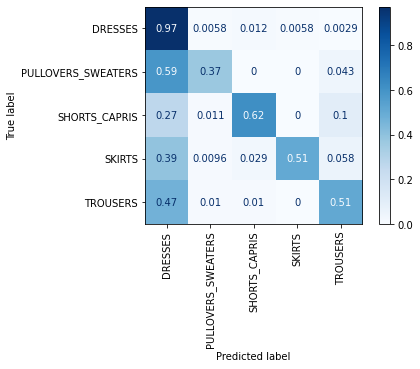




------------------------------------------------------------
                    precision    recall  f1-score   support

           DRESSES       0.71      0.97      0.82       345
          TROUSERS       0.77      0.37      0.50        46
            SKIRTS       0.87      0.62      0.72        89
     SHORTS_CAPRIS       0.96      0.51      0.67       104
PULLOVERS_SWEATERS       0.74      0.51      0.60        98

          accuracy                           0.75       682
         macro avg       0.81      0.60      0.66       682
      weighted avg       0.78      0.75      0.73       682

------------------------------------------------------------




In [10]:
clf_pipe = quick_pipeline(best_model, best_model_name, X_train, X_test, y_train, y_test, plot=True, return_type = 'classifier')

### Save Best model with Pickle

In [11]:
filename = 'Baseline_model2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf_pipe, file)

## Model evaluation

In [12]:
df_eval = pd.concat([X_test, y_test], axis=1)
(df_eval["category1"], 
df_eval["category2"], 
df_eval["category1_prob"],
df_eval["category2_prob"]) = (quick_pipeline(best_model,
                                              best_model_name, X_train, X_test,
                                              y_train, y_test, plot=False,
                                              return_type ='predictions')
                              )





#### Failed predictions (first and second guess)

In [13]:
pd.set_option('max_colwidth', 400)

guessed_first = (df_eval["cc3"] != df_eval["category1"])
guessed_second = (df_eval["cc3"] != df_eval["category2"])
                 
df_eval[guessed_first & guessed_second].sort_values(by=["category1_prob", "category2_prob"], ascending=False).head(50)

,description_proc,cc3,category1,category2,category1_prob,category2_prob
2104,pretti crop trouser hard worn,SHORTS_CAPRIS,TROUSERS,DRESSES,0.815500,0.074387
2360,length,TROUSERS,DRESSES,SKIRTS,0.676106,0.128825
2066,post royal mail everi friday light perfect summer possibl crop jean size trouser,SHORTS_CAPRIS,TROUSERS,DRESSES,0.674353,0.106392
2228,perfect jean dress skirt pinafor,PULLOVERS_SWEATERS,DRESSES,SKIRTS,0.610235,0.275727
2750,look size great condit criss cross side short make offer,SKIRTS,SHORTS_CAPRIS,DRESSES,0.599205,0.195060
1315,tag blush pink print lacey around outer edg accept reason offer,PULLOVERS_SWEATERS,DRESSES,TROUSERS,0.588626,0.135049
1286,bought holiday didn chanc wear brand without tag button front,SKIRTS,DRESSES,TROUSERS,0.557061,0.152595
1094,velikost odpovídá,SKIRTS,DRESSES,TROUSERS,0.547976,0.183001
2387,without tag,SKIRTS,DRESSES,SHORTS_CAPRIS,0.544808,0.178943
1869,size immacul condit post hour monday friday free postag order discount bundl shop polici found profil smart casual workwear summer spring autumn winter topshop riverisland zara next newlook whistl hobb primark vintag karenmillen reiss debenham pimki bershka mango aso papaya principl peruna missguid missselfridg georg monsoon veromoda,SKIRTS,DRESSES,TROUSERS,0.520033,0.151167


#### Predicted with first guess

In [14]:
pd.set_option('max_colwidth', 400)
df_eval[(df_eval["cc3"] == df_eval["category1"])].head(10)

,description_proc,cc3,category1,category2,category1_prob,category2_prob
32,worn immacul condit amaz,DRESSES,DRESSES,SKIRTS,0.525123,0.193721
871,labai daili keli kartus vilkėta gėlėta suknelė ryškio spalvo nenublukusi atitinka dydį,DRESSES,DRESSES,SHORTS_CAPRIS,0.800981,0.068605
1995,pacsun short size high waist comfi great condit true size fit size,SHORTS_CAPRIS,SHORTS_CAPRIS,TROUSERS,0.751236,0.104244
3026,sold švelnio pastelė suknelė labai gražio spalvo puikio būklės marškinių tipo apykaklė juosmuo guma dydi,DRESSES,DRESSES,SHORTS_CAPRIS,0.605327,0.133150
192,tag,DRESSES,DRESSES,TROUSERS,0.577114,0.159870
1616,topshop kolekcijo vinyl editor straight jean kelnė tiesaus kirpimo aukštinto liemen žvilgančio audinio kelnė nepriekaištingai priglunda sukuria dailų siluetą unikalio visada stilingo lengvai derinamo aprangoj lookbook nuotrauko https imag topshop topshop rblk_m_ webp https imag topshop topshop rblk_m_ webp https imag topshop topshop rblk_m_ webp topshop black vinyl editor straight jean,TROUSERS,TROUSERS,DRESSES,0.441430,0.185319
2894,prodám kalhoti stav nesedí originál pošta,TROUSERS,TROUSERS,DRESSES,0.501857,0.205429
1689,černé lesklé kalhoti vhodné drobnou postavu průměr pase délka pozor nejsou elastické punk rock metal goth,TROUSERS,TROUSERS,DRESSES,0.454736,0.300464
134,visiškai nauja dryžuota storo audinio monki suknelė siuntima paštomatus express omniva nerezervuoju,DRESSES,DRESSES,PULLOVERS_SWEATERS,0.774974,0.069972
862,graži paprasta sunkelė tinka,DRESSES,DRESSES,TROUSERS,0.647232,0.105147


In [15]:
dataframe = pd.read_parquet('workspace/academy/assignment1/data/test.parquet')
dataframe.shape

(946, 4)

In [16]:
t = time.time()
clf = Classifier_pipe(dataframe, 'description', 'Baseline_model2.pkl')
clf.predict_top2()
print(f'total time: {time.time() - t}')

preprocess: 1.1524763107299805
inference: 0.018090009689331055
saving to .parquet: 0.03768587112426758
total time: 1.2203292846679688


In [17]:
df_temp = pd.read_parquet('predictions.parquet')
df_temp.head(10)

,uuid,description,color,price,category1,category2
0,00_04fec_bcBubyJW2q8o6JPFntUn4Q9W,"In great condition! No holes, stains or pilling. \n\nSize 26. \n\nStyle is Skinny Toothpick. \n\nMade of 99% cotton, 1% spandex. \n\nSmoke free home. All sales are final.\n\n#jcrew\n#corduroy\n#skinnyjeans",GREY,11.4000,TROUSERS,DRESSES
1,00_050a7_o9o8NLTcXJ7Hqs2t31xEGoG4,"šiek tiek praires užtrauktukas ,reiktų šiek tiek\nsuimt su siūlu . ne auksteniai nei 170cm \nPrašau neprašykite išmatavimų nuo pažasties iki klyno ir pan. Visi dydžiai yra standartiniai ,jei neparašyta kitaip. Nemainau.",WHITE,5.0000,DRESSES,TROUSERS
2,00_060f0_zLp2b8moCnfWX614ZAu8HfsS,This square neckline dress is so beautiful! It’s sheer and printed. It’s a pretty turquoise blue color. The back ties. It’s asymmetrical and ruched at one side. The brand is Cabi. Size small.,BLUE,26.6000,DRESSES,SKIRTS
3,00_05d49_74iqVSd8yami4Szoy5tBjkGF,"Maxi sukně ze zajímavého materiálu, tak trošku mění barvu na světle. Vysoký pas. Super objem, skoro princeznovská:)\n\n#dlouhasukne #maxisukne #sukne #zajímavý #zajímavá #zajimavabarva #material #lesklý #lesklá #extravagantni",PINK,4.6680,SKIRTS,DRESSES
4,00_06301_twfaovSeAmiJoFPWgAE9b99G,"Labai graži suknelė, yra maža dėmelė,kuri tikrak išsiplaus",BLACK,5.0000,DRESSES,SKIRTS
5,0657b_ekzpmzqL7oBv5oXYEG2k97TM,"příjemná pružná viskoza, vhodné na běžné nošení, jako těhotenské, nebo i kojící, délka 100cm hrudník 2x58+ cm\nZNAČKA: NEXT\nVELIKOST: 46",WHITE,9.6861,DRESSES,TROUSERS
6,06a1d_nZKKntEeKSQ8Kv45ymvw4zFB,Purple Papaya Denim Jeggings\nWorn few times\nIn great condition,PURPLE,1.8000,SHORTS_CAPRIS,DRESSES
7,00_04e38_dCq1Da2WcC9pprqP2AzR4pcw,"Labai graži, nauja suknelė eu 36 d. Uk 8d. Su blizgučiu. 92% polesteris, 4% elastanas",BODY,12.0000,DRESSES,SKIRTS
8,00_06664_ZAsYsk3pPhFsKoDFmwNUvACW,"Letní teplákové pruhované šaty H&M, velikost XS, velice příjemné s postranními kapsami",GREY,3.8900,DRESSES,TROUSERS
9,00_0685a_iDRZjgbPPBKhzKr9WHRi5DJk,"Krátké pruhované bavlněné šatky, super stav - nošené, ale bez vad. Hodně elastické, délka nad kolena. Neunosím.",BODY,3.8900,DRESSES,TROUSERS
